In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from arguments import parse_args
from main import train, get_data
from dataset import LocalizationDataset
from torch.utils.data import DataLoader
import os
from cust_model import Tracker, TrackingDataset
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
amzn_data = pd.read_csv("AMZN28.csv").set_index("DateTime").drop('Unnamed: 0', axis = 1, inplace = False)

In [4]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict({"num_trajs":1000,
        "sl":100,
        "batch_size":128,
        "num_particles":30,
        "window_length":6,
        "h":64,
        "emb_obs":23,
        "emb_act":32,
        "dropout":0.1, #we changed this from 0.5
        "obs_num":5,
        "resamp_alpha":0.5,
        "bp_length":10, 
        "clip":1.0,
        "lr":0.0005,
        "bpdecay":0.1,
        "l2_weight":1.0,
        "l1_weight":0.0})

In [5]:
amznnp = amzn_data.to_numpy()

In [6]:
inlen = args.sl*(len(amznnp) // args.sl)
inputs_window = np.array([amznnp[i-args.window_length:i] for i in range(args.window_length,len(amznnp))])[:inlen]
outputs = amznnp[args.window_length:inlen+args.window_length,1]

In [7]:
inputs_prebatch = inputs_window.reshape(inlen // args.sl, args.sl, -1)
outputs_prebatch = outputs.reshape(inlen // args.sl, args.sl)

In [8]:
train_dataset = TrackingDataset(inputs_prebatch, outputs_prebatch)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                            num_workers=8, pin_memory=True, shuffle=False, drop_last = True)
model = Tracker(args)
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.lr)

In [ ]:
cnt = 0
best_eval = 1000
from tqdm import tqdm

losses = []

print("starting epochs")
for epoch in tqdm(range(10)):
    # print("going to train")
    model.train() #just a toggle switch

    # print("starting iterations")
    for iteration, data in enumerate(train_loader):
        cnt = cnt + 1

        output, window = data
        model.zero_grad()
        loss, log_loss, particle_pred = model.step(
            window, output, args)
        loss.backward()

        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()

        loss_last = log_loss.to('cpu').detach().numpy()
        loss_all = loss.to('cpu').detach().numpy()
        losses.append([loss_last, loss_all])


In [15]:
lnp

array([[   9609.085, 1121378.   ],
       [   8766.981, 1153893.9  ],
       [   9591.403, 1118693.4  ],
       [   8742.977, 1150986.9  ],
       [   9566.325, 1115490.4  ],
       [   8726.84 , 1148653.4  ],
       [   9553.358, 1113736.8  ],
       [   8711.567, 1147080.4  ],
       [   9543.541, 1112669.1  ],
       [   8703.682, 1146204.   ],
       [   9536.286, 1111679.4  ],
       [   8698.302, 1145416.2  ],
       [   9529.914, 1111272.   ],
       [   8696.528, 1145081.5  ],
       [   9526.849, 1110863.8  ],
       [   8691.089, 1144550.   ],
       [   9525.618, 1110515.5  ],
       [   8689.87 , 1144356.2  ],
       [   9520.51 , 1110336.6  ],
       [   8688.55 , 1144201.1  ]], dtype=float32)

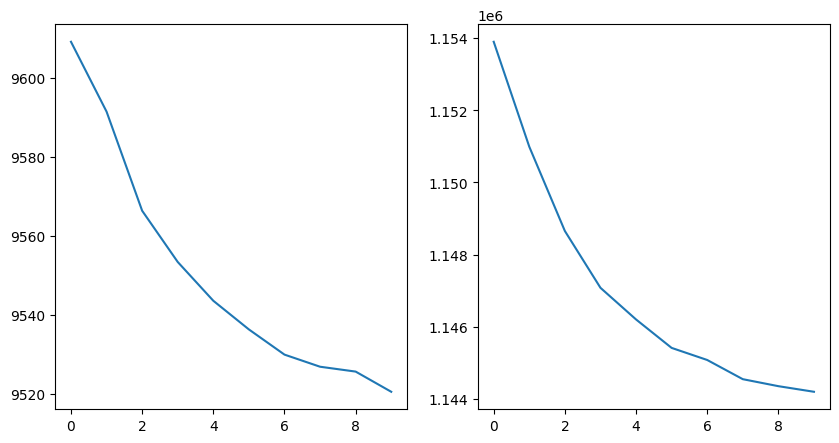

In [16]:
lnp = np.array(losses)
fig, (ax0,ax1) = plt.subplots(1,2,figsize = (10,5))
ax0.plot(lnp[::2,0])
ax1.plot(lnp[1::2,1])